In [1]:
from hig_data.coco import COCOStuffGraphPrecomputedDataset
import torch
path = '/Users/rupertmenneer/Downloads/coco_graph_train'
coco_graph = COCOStuffGraphPrecomputedDataset(path)
data = coco_graph[10]
data

Found 118287 complete datapoint in /Users/rupertmenneer/Downloads/coco_graph_train
torch.Size([1024, 1])


RelaxedHeteroData(
  image=[1, 8, 32, 32],
  mask=[1, 1, 256, 256],
  mask_path='/Users/rupertmenneer/Downloads/coco_graph_train/00000010_mask.npy',
  image_node={
    x=[1024, 1],
    pos=[1024, 2],
  },
  class_node={
    x=[2, 183],
    pos=[2, 2],
    label=[2],
  },
  (class_node, class_edge, class_node)={ edge_index=[2, 2] },
  (class_node, class_to_image, image_node)={ edge_index=[2, 1021] }
)

In [16]:
data['class_to_image']

{'edge_index': tensor([[  0,   0,   0,  ...,   1,   1,   1],
        [ 16,  17,  18,  ..., 993, 994, 995]])}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the 2nd column from edge_index
linear_image_ids = data['class_to_image'].edge_index[1]
class_image_ids = data['class_to_image'].edge_index[0]

# Initialize a 32x32 image with zeros
image = np.zeros((32, 32))

# Convert linear indices to 2D indices and set the corresponding pixels to 1
for idx in range(len(linear_image_ids)):
    img_idx = linear_image_ids[idx]
    class_idx = class_image_ids[idx]
    row = img_idx // 32
    col = img_idx % 32
    image[row, col] = class_idx + 1

# Display the image
plt.imshow(image,)

plt.show()

In [ ]:
import PIL
image_data = np.load(data.mask_path)
print(image_data.shape)
plt.imshow(image_data.transpose(1, 2, 0))

In [ ]:
import torch
class_labels = torch.argmax(data['class_node'].x[:, 1:], dim=1)
class_labels

In [6]:
from torch_geometric.loader import DataLoader as GeoDataLoader
dls = GeoDataLoader(coco_graph, batch_size=32, shuffle=True)
graph_batch = next(iter(dls))
graph_batch

# graph_batch['image_node'].pos, graph_batch['class_node'].pos

torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])
torch.Size([1024, 1])


RelaxedHeteroDataBatch(
  image=[32, 8, 32, 32],
  mask=[32, 1, 256, 256],
  mask_path=[32],
  image_node={
    x=[32768, 1],
    pos=[32768, 2],
    batch=[32768],
    ptr=[33],
  },
  class_node={
    x=[260, 183],
    pos=[260, 2],
    label=[260],
    batch=[260],
    ptr=[33],
  },
  (class_node, class_edge, class_node)={ edge_index=[2, 2726] },
  (class_node, class_to_image, image_node)={ edge_index=[2, 30645] }
)

In [32]:
graph_batch['class_to_image']

{'edge_index': tensor([[   0,    0,    0,  ...,   11,   11,   11],
        [ 204,  236,  267,  ..., 2019, 2020, 2021]])}

In [11]:
batch_list = graph_batch.to_data_list()
batch_list[1]


RelaxedHeteroData(
  image=[1, 8, 32, 32],
  mask=[1, 1, 256, 256],
  mask_path='/Users/rupertmenneer/Downloads/coco_graph_train/00099649_mask.npy',
  image_node={
    x=[1024, 1],
    pos=[1024, 2],
  },
  class_node={
    x=[20, 183],
    pos=[20, 2],
    label=[20],
  },
  (class_node, class_edge, class_node)={ edge_index=[2, 380] },
  (class_node, class_to_image, image_node)={ edge_index=[2, 1022] }
)

In [7]:
from training.networks_edm2_hignn import Precond
precond = Precond(32, 4, gnn_metadata = graph_batch.metadata())

In [8]:

hignn = precond.unet.init_hignn
blank_image = torch.zeros((32, 192, 32, 32))
out, new_graph = hignn(blank_image, graph_batch.clone())
out.shape

torch.Size([32, 192, 32, 32])

In [ ]:
out_split.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


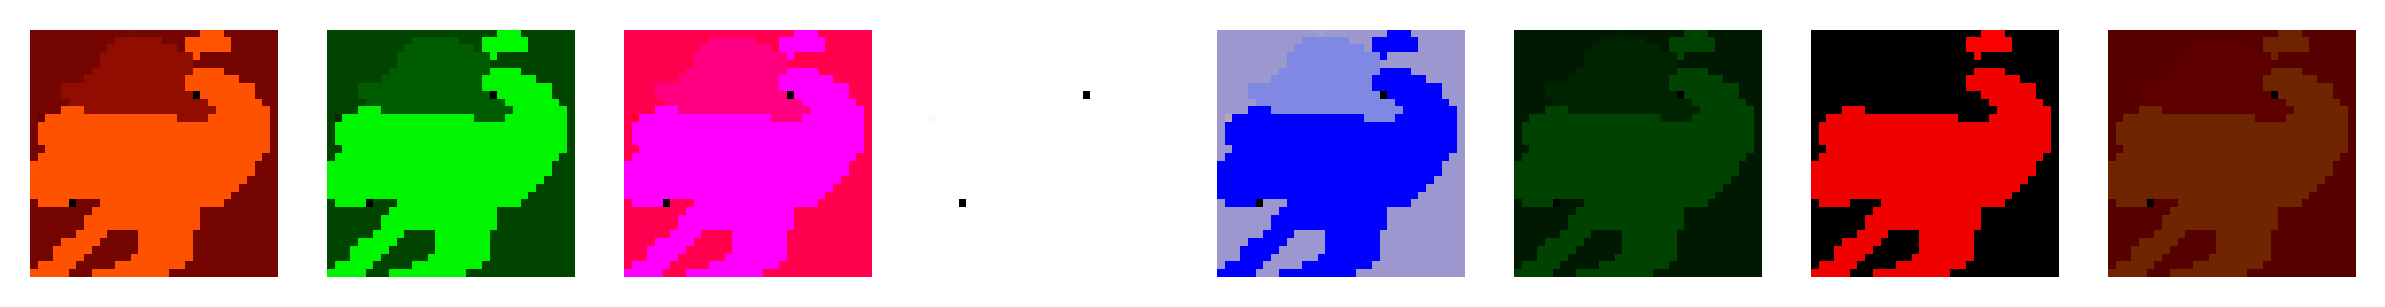

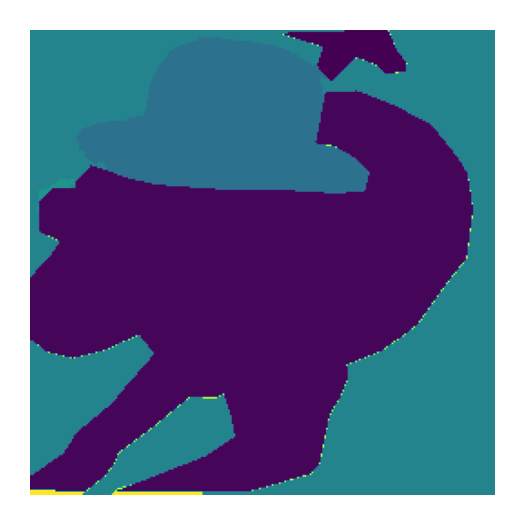

In [15]:
from hig_data.visualisation import plot_array_images
i = 5
out_split = torch.cat(torch.chunk(out[i:i+1], 64, dim=1), dim=0)
plot_array_images(out_split.detach())
plot_array_images(batch_list[i].mask)

In [ ]:
precond.unet.enc['32x32_block0'].emb_linear.weight.shape, precond.unet.enc['32x32_block0'].hignn.gnn.gnn_layers[0]['image_node'].weight.shape

In [ ]:
precond.unet.enc['32x32_block0'].hignn.gnn.gnn_layers[0]['image_node'].weight

In [ ]:
import torch
torch.set_printoptions(precision=20)
out[1]

In [ ]:
import torch
images = torch.randn(1, 3, 32, 32)
rnd_normal = torch.randn([images.shape[0], 1, 1, 1], device=images.device)
sigma = (rnd_normal).exp()

data = coco_graph[1]
out = precond(images, sigma, data)
out.shape

In [ ]:
from training.training_loop_hignn import training_loop
import torch
from torch_utils import distributed as dist
torch.multiprocessing.set_start_method('spawn')
dist.init()
dist.print0('Setting up training config...')
training_loop(dataset_kwargs=dict(class_name='hig_data.coco.CocoStuffGraphDataset',
image_path=img_path, mask_path=mask_path, latent_images=True),)